# Wavefront propagation simulation tutorial - Case 3_new

L.Samoylova <liubov.samoylova@xfel.eu>, A.Buzmakov <buzmakov@gmail.com>

Tutorial course on Wavefront Propagation Simulations, 28/11/2013, European XFEL, Hamburg.

Wave optics software is based on SRW core library <https://github.com/ochubar/SRW>, available through WPG interactive framework <https://github.com/samoylv/WPG>

## Propagation Gaussian through HOM and KB optics: extended analysis

### Import modules

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Importing necessary modules:

import os
import sys
sys.path.insert(0,os.path.join('..','..'))

import time
import copy
import numpy
import pylab


#import SRW core functions
from wpg.srwlib import           srwl,SRWLOptD,SRWLOptA,SRWLOptL,     SRWLOptMirEl,SRWLOptT,SRWLOptC

from wpg.optical_elements import         Drift,Aperture,    Lens,Mirror_elliptical,WF_dist,calculateOPD

#import SRW helpers functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh, plot_1d, plot_2d
from wpg.useful_code.wfrutils import propagate_wavefront
 
#Import base wavefront class
from wpg import Wavefront

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP

pylab.ion()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from . import _conv
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/_hl/group.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p


In [3]:
NEW_SYNTAX = True

### Define auxiliary functions

In [4]:
def _resample(wf, axis, data, x0, x1):
    if axis.lower()=='x':
        y = data[data.shape[0]/2,:]
        x = numpy.linspace(wf.params.Mesh.xMin, wf.params.Mesh.xMax, y.shape[0])
    elif axis.lower()=='y':
        y = data[:,data.shape[1]/2]
        x = numpy.linspace(wf.params.Mesh.yMin, wf.params.Mesh.yMax, y.shape[0])
    else:
        raise ValueError(
            'Wrong axis {}, should be "x" or "y"'.format(axis))
    
    if not x0 is None:
        xmin = x0
    else:
        xmin = x[0]
    
    if not x1 is None:
        xmax = x1
    else:
        xmax = x[-1] 
    
    x1 = numpy.linspace(xmin,xmax,len(y))
    y1 = numpy.interp(x1, x,y)
    return x1, y1
    
def intensity_cut(wf, axis, polarization, x0=None, x1=None):
    
    if polarization.lower()  == 'v' or polarization.lower() == 'vertical':
        pol = 'vertical'
    elif polarization.lower() == 'h' or polarization.lower() == 'horizontal':
        pol = 'horizontal'
    elif polarization.lower() == 't' or polarization.lower() == 'total':
        pol = 'total'
    else:
        raise ValueError(
            'Wrong polarization {}, should be "v" or "vertical"'+
            ' or "h" or "horizontal" or "t" or "total"'.format(polarization))
    
    data = wf.get_intensity(slice_number=0, polarization=pol)
    return _resample(wf, axis, data, x0, x1)

def phase_cut(wf, axis, polarization, x0=None, x1=None):
    
    if polarization.lower()  == 'v' or polarization.lower() == 'vertical':
        pol = 'vertical'
    elif polarization.lower() == 'h' or polarization.lower() == 'horizontal':
        pol = 'horizontal'
    else:
        raise ValueError(
            'Wrong polarization {}, should be "v" or "vertical" or "h" or "horizontal"'.format(polarization))
    
    data = wf.get_phase(slice_number=0, polarization=pol)
    return _resample(wf, axis, data, x0, x1)

In [5]:
def calculate_source_fwhm(ekev, theta_fwhm):
    """
    Calculate source size from photon energy and FWHM angular divergence
    
    :param evev: Energy in keV
    :param theta_fwhm: theta_fwhm [units?] 
    """
    wl = 12.39e-10/ekev
    k = 2 * numpy.sqrt(2*numpy.log(2))
    theta_sigma = theta_fwhm /k
    sigma0 = wl /(2*numpy.pi*theta_sigma)
    return sigma0*k

def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011
    
    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * numpy.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

def defineOPD(opTrErMirr, mdatafile, ncol, delim, Orient, theta, scale):
    """
    Define optical path difference (OPD) from mirror profile, i.e. ill the struct opTrErMirr
    
    :params mdatafile: an ascii file with mirror profile data
    :params ncol: number of columns in the file
    :params delim: delimiter between numbers in an row, can be space (' '), tab '\t', etc
    :params orient: mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :params theta: incidence angle
    :params scale: scaling factor for the mirror profile    
    """
    heightProfData = numpy.loadtxt(mdatafile).T
    AuxTransmAddSurfHeightProfileScaled(opTrErMirr, heightProfData, Orient, theta, scale)
    pylab.figure()
    plot_1d(heightProfData,'profile from ' + mdatafile,'x (m)', 'h (m)')

In [6]:
def defineEFM(orient,p,q,thetaEFM,theta0,lengthEFM):
    """
    A wrapper to a SRWL function SRWLOptMirEl() for defining a plane elliptical focusing mirror propagator
    
    :param Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :param p:  the distance to two ellipsis centers
    :param q:  the distance to two ellipsis centers
    :param thetaEFM:  the design incidence angle in the center of the mirror
    :param theta0:    the "real" incidence angle in the center of the mirror
    :param lengthEFM: mirror length, [m]
    :return: the struct opEFM
    """
    if orient == 'x':     #horizontal plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM, 
            _nvx=cos(theta0), _nvy=0, _nvz=-sin(theta0), _tvx=-sin(theta0), _tvy=0, _x=0, _y=0, _treat_in_out=1) 
    elif orient == 'y': #vertical plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM, 
            _nvx=0, _nvy=cos(theta0), _nvz=-sin(theta0), _tvx=0, _tvy=-sin(theta0), _x=0, _y=0, _treat_in_out=1)
    else:
        raise TypeError('orient should be "x" or "y"')
    return opEFM

### Defining initial wavefront and writing electric field data to h5-file

*****defining initial wavefront and writing electric field data to h5-file...
waist_fwhm [um], theta_fwhms [urad]: 28.3217691481 3.86399794107
save hdf5: g5_0kev.h5


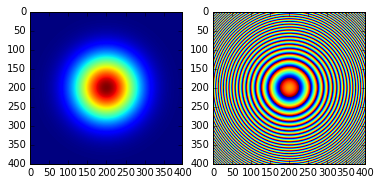

FWHMx [mm]: 0.943784566665
FWHMy [mm]: 0.943784566665
Coordinates of center, [mm]: 0.0035480622807 0.0035480622807
stepX, stepY [um]: 7.09612456139 7.09612456139 

FWHMx [mm], theta_fwhm [urad]: 0.943784566665 3.82874063556


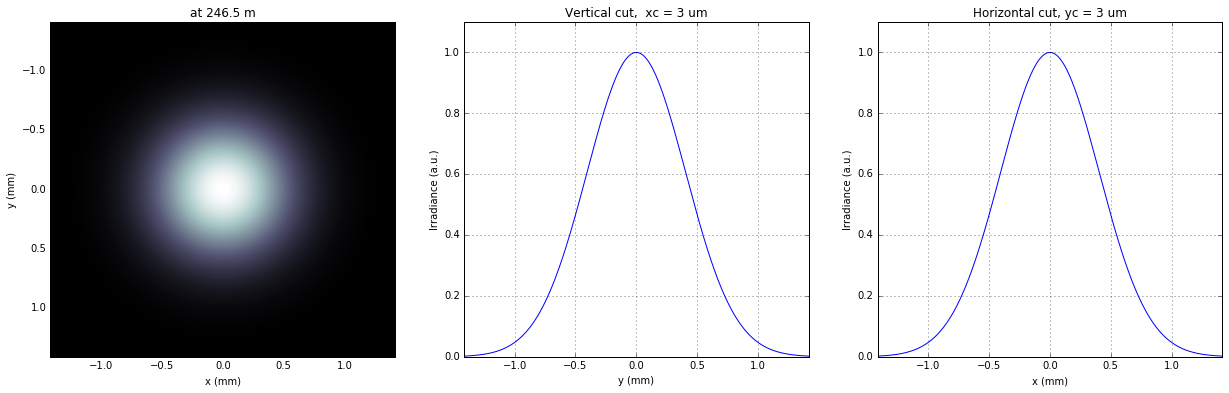

In [7]:
# #**********************Input Wavefront Structure and Parameters
print('*****defining initial wavefront and writing electric field data to h5-file...')
strInputDataFolder = 'data_common'  # input data sub-folder name
strOutputDataFolder = 'Tutorial_case_3'  # output data sub-folder name

#init Gauusian beam parameters
d2m1_sase1 = 246.5
d2m1_sase2 = 290.0
d2m1_sase3 = 281.0

d2hkb_sase1 = 929.6       # distance to nmKB's HFM
dHKB_foc_sase1 = 3.0      # nominal focal length for HFM KB
dVKB_foc_sase1 = 1.9      # nominal focal length for VFM KB
d2hkb_sase3 = 442.3
dHKB_foc_sase3 = 2.715    # nominal focal length for HFM KB
dVKB_foc_sase3 = 1.715    # nominal focal length for VFM KB


qnC = 0.1                    # e-bunch charge, [nC]
ekev_sase3 = 0.8
thetaOM_sase3 = 9.e-3
thetaKB_sase3 = 9.e-3
ekev_sase1 = 5.0
thetaOM_sase1 = 3.5e-3       # 
thetaKB_sase1 = 3.5e-3

ekev = ekev_sase1
thetaOM = thetaOM_sase1
d2m1 = d2m1_sase1
d2hkb = d2hkb_sase1
thetaKB = thetaKB_sase1
dhkb_foc = dHKB_foc_sase1     # nominal focal length for HFM KB
dvkb_foc = dVKB_foc_sase1      # nominal focal length for VFM KB
dhkb_vkb = dhkb_foc - dvkb_foc          # distance between centers of HFM and VFM

z1 = d2m1
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*sqrt(2*log(2))
sigX = 12.4e-10*k/(ekev*4*pi*theta_fwhm) 
print 'waist_fwhm [um], theta_fwhms [urad]:', sigX*k*1e6, theta_fwhm*1e6
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size
np=400

#define unique filename for storing results
ip = floor(ekev)
frac = numpy.floor((ekev - ip)*1e3)
fname0 = 'g' + str(int(ip))+'_'+str(int(frac))+'kev'
print('save hdf5: '+fname0+'.h5')
ifname = os.path.join(strOutputDataFolder,fname0+'.h5')

#tiltX = theta_rms
#build SRW gauusian wavefront
wfr0=build_gauss_wavefront_xy(nx=np, ny=np, ekev=ekev,
                              xMin=-range_xy/2, xMax=range_xy/2,
                              yMin=-range_xy/2, yMax=range_xy/2,
                              sigX=sigX, sigY=sigX, d2waist=z1,
                              xoff=0, yoff=0, tiltX=0, tiltY=0)    

#init WPG Wavefront helper class
mwf = Wavefront(wfr0)

#store wavefront to HDF5 file 
mwf.store_hdf5(ifname)

#draw wavefront with common functions
pylab.subplot(1,2,1)
pylab.imshow(mwf.get_intensity(slice_number=0))
pylab.subplot(1,2,2)
pylab.imshow(mwf.get_phase(slice_number=0,polarization='horizontal'))
pylab.show()

#draw wavefront with cuts
plot_wfront(mwf, title_fig='at '+str(z1)+' m',
            isHlog=False, isVlog=False,
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True)

pylab.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
fwhm_x = calculate_fwhm_x(mwf)
print 'FWHMx [mm], theta_fwhm [urad]:',fwhm_x*1e3,fwhm_x/z1*1e6

### Defining optical beamline(s) 

In [8]:
print('*****Defining optical beamline(s) ...')

z2 = d2hkb - d2m1

dhkb_vkb = dhkb_foc - dvkb_foc          # distance between centers of HFM and VFM
z3 = dhkb_vkb

d2vkb = d2hkb +  dhkb_vkb
vkbfoc =  1. /(1./dvkb_foc + 1. / d2vkb) # for thin lens approx
hkbfoc =  1. /(1./dhkb_foc + 1. / d2hkb) # for thin lens approx 
z4 = vkbfoc                              #distance to focal plane

horApM1 = 0.8*thetaOM
horApKB = 0.8 * thetaKB # Aperture of the KB system, CA 0.8 m
scale = 2     #5 mirror profile scaling factor 

if not NEW_SYNTAX: 
    DriftM1_KB = SRWLOptD(z2) #Drift from first offset mirror (M1) to exp hall

    opApM1 = SRWLOptA('r', 'a', horApM1, range_xy)  # clear aperture of the Offset Mirror(s)
    opApKB = SRWLOptA('r', 'a', horApKB, horApKB)  # clear aperture of the Offset Mirror(s)

#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                     [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
    ppM1 =            [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppTrErM1 =        [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppDriftM1_KB =    [ 0,  0, 1.0,  1,  0, 2.4, 1.8, 2.4, 1.8,  0,  0,   0]
    ppApKB =          [ 0,  0, 1.0,  0,  0, 0.6, 8.0, 0.6, 4.0,  0,  0,   0]
    ppHKB =           [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppTrErHKB =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppDrift_HKB_foc = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppDrift_KB =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppVKB =           [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppTrErVKB =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppDrift_foc =     [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    #ppFin  =          [ 0,  0, 1.0,  0,  0, 0.05,5.0, 0.05,5.0,  0,  0,   0]
    ppFin =           [ 0,  0, 1.0,  0,  1, .01, 20.0, .01, 20.0,  0,  0,   0]

    optBL0 = SRWLOptC([opApM1,  DriftM1_KB], 
                      [ppM1,ppDriftM1_KB]) 
    print('*****HOM1 data for BL1 beamline ')
    opTrErM1 = SRWLOptT(1500, 100, horApM1, range_xy)
    #defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror1.dat'), 2, '\t', 'x',  thetaOM, scale)
    defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror2.dat'), 2, ' ', 'x',  thetaOM, scale)
    #opdTmp=numpy.array(opTrErM1.arTr)[1::2].reshape(opTrErM1.mesh.ny,opTrErM1.mesh.nx)
    #figure()
    #plot_2d(opdTmp, opTrErM1.mesh.xStart*1e3,opTrErM1.mesh.xFin*1e3,opTrErM1.mesh.yStart*1e3,opTrErM1.mesh.yFin*1e3,
    #        'OPD [m]', 'x (mm)', 'y (mm)')  
    optBL1 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB], 
                      [ppM1,ppTrErM1,ppDriftM1_KB]) 

    #HKB = SRWLOptMirEl(_p=d2hkb, _q=dhkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=cos(thetaKB), _nvy=0, _nvz=-sin(thetaKB), _tvx=-sin(thetaKB), _tvy=0, _x=0, _y=0, _treat_in_out=1) #HKB Ellipsoidal Mirror
    #VKB = SRWLOptMirEl(_p=d2vkb, _q=dvkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=0, _nvy=cos(thetaKB), _nvz=-sin(thetaKB), _tvx=0, _tvy=-sin(thetaKB), _x=0, _y=0, _treat_in_out=1) #VKB Ellipsoidal Mirror
    #HKB = SRWLOptL(hkbfoc) #HKB as Thin Lens
    #VKB = SRWLOptL(1e23,vkbfoc) #VKB as Thin Lens
    HKB = defineEFM('x', d2hkb, dhkb_foc, thetaKB, thetaKB, 0.85) #HKB Ellipsoidal Mirror
    VKB = defineEFM('y', d2vkb, dvkb_foc, thetaKB, thetaKB, 0.85) #VKB Ellipsoidal Mirror
    Drift_KB  = Drift(z3)
    Drift_foc = Drift(z4)
    optBL2 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,   Drift_KB,  VKB,  Drift_foc], 
                      [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppDrift_KB,ppVKB,ppDrift_foc,ppFin]) 
else:
    optBL0 = Beamline()
    optBL0.append(Aperture(shape='r',ap_or_ob='a',Dx=horApM1,Dy=range_xy),
                  Use_PP())
    optBL0.append(Drift(z2),
                  Use_PP(semi_analytical_treatment=1, zoom=2.4, sampling=1.8))
    
    opOPD_M1 = calculateOPD(WF_dist(nx=1500,ny=100,Dx=horApM1,Dy=range_xy),
                            os.path.join(strInputDataFolder,'mirror2.dat'),
                            2, ' ', 'x',  thetaOM, scale)
    optBL1 = Beamline()
    optBL1.append(Aperture(shape='r',ap_or_ob='a',Dx=horApM1,Dy=range_xy),
                  Use_PP())
    optBL1.append(opOPD_M1,Use_PP())
    optBL1.append(Drift(z2),
                  Use_PP(semi_analytical_treatment=1, zoom=2.4, sampling=1.8))
    

    optBL2 = copy.deepcopy(optBL1)
    optBL2.append(Aperture(shape='r',ap_or_ob='a',Dx=horApKB,Dy=horApKB),
                  Use_PP(zoom_h=0.6, sampling_h=8.0, zoom_v=0.6, sampling_v=4.0))
    optBL2.append(Mirror_elliptical(orient='x',p=d2hkb,q=dhkb_foc,thetaE=thetaKB,theta0=thetaKB,length=0.85),
                  Use_PP())
    optBL2.append(Drift(z3), Use_PP())
    optBL2.append(Mirror_elliptical(orient='y',p=d2vkb,q=dvkb_foc,thetaE=thetaKB,theta0=thetaKB,length=0.85),
                  Use_PP())
    optBL2.append(Drift(z4), Use_PP())
    optBL2.append(Empty,
                  Use_PP(fft_resizing=1,zoom=0.01, sampling=20.))


*****Defining optical beamline(s) ...


### Propagating through BL1 beamline. Imperfect mirror, at KB aperture

In [9]:
print ('*****Imperfect HOM mirror, at KB aperture')
bPlotted = False
isHlog = True
isVlog = False
bSaved = True
optBL = optBL1
strBL = 'bl1'
pos_title = 'at exp hall wall'
print '*****setting-up optical elements, beamline:', strBL

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print 'save hdf5:', out_file_name
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, optBL,out_file_name)
print 'propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min'

*****Imperfect HOM mirror, at KB aperture
*****setting-up optical elements, beamline: bl1
save hdf5: Tutorial_case_3/g5_0kev_bl1.h5
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028
	Dy = 0.0028313537
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 683.1
	treat = 0
	

*****reading wavefront from h5 file...
nx   400  range_x [-1.4e-03, 1.4e-03]
ny   400  range_y [-1.4e-03, 1.4e-03]
*****propagating wavefront (with resizing)...
save hdf5: Tutorial_case_3/g5_0kev_bl1.h5
done
propagation lasted: 0.1 min


*****Imperfect HOM mirror, at KB aperture
FWHMx [mm]: 3.58587015917
FWHMy [mm]: 3.5521100211
Coordinates of center, [mm]: -0.0489386746289 0.0134210706087
stepX, stepY [um]: 8.89794084161 8.9473804058 

FWHMx [mm], theta_fwhm [urad]: 3.58587015917 3.85743347587
FWHMy [mm], theta_fwhm [urad]: 3.5521100211 3.82111663199


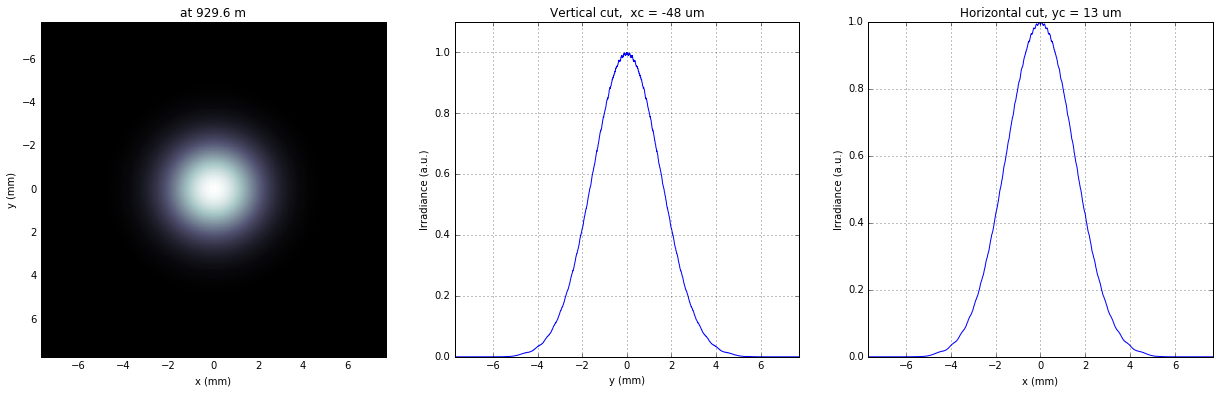

In [10]:
print ('*****Imperfect HOM mirror, at KB aperture')
plot_wfront(mwf, 'at '+str(z1+z2)+' m',False, False, 1e-5,1e-5,'x', True)
#pylab.set_cmap('bone') #set color map, 'bone', 'hot', etc
pylab.axis('tight')    
print 'FWHMx [mm], theta_fwhm [urad]:',calculate_fwhm_x(mwf)*1e3,calculate_fwhm_x(mwf)/(z1+z2)*1e6
print 'FWHMy [mm], theta_fwhm [urad]:',calculate_fwhm_y(mwf)*1e3,calculate_fwhm_y(mwf)/(z1+z2)*1e6

In [11]:
@TODO: do further

SyntaxError: invalid syntax (<ipython-input-11-240607a69618>, line 1)

### Propagating through BL2 beamline. Focused beam: perfect KB

In [12]:
print ('*****Focused beam: perfect KB')
bSaved = False

optBL = optBL2
strBL = 'bl2'
pos_title = 'at sample position'
print '*****setting-up optical elements, beamline:', strBL
if not NEW_SYNTAX: 
    bl = Beamline(optBL)
    bl.append(Empty(), Use_PP(zoom=0.02, sampling=5.0))
    print bl

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print 'save hdf5:', out_file_name
else:
    out_file_name = None
    
startTime = time.time()
if not NEW_SYNTAX: mwf = propagate_wavefront(ifname, bl,out_file_name)
    
print 'propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min'

*****Focused beam: perfect KB
*****setting-up optical elements, beamline: bl2
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028
	Dy = 0.0028313537
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0014
		xStart = -0.0014
		yFin = 0.00141567685
		yStart = -0.00141567685
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 683.1
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 0.6, 8.0, 0.6, 4.0, 0, 0, 0]
	Dx = 0.0028
	Dy = 0.0028
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Mir

*****Focused beam: Focused beam: perfect KB
FWHMx [mm]: 0.000234646744853
FWHMy [mm]: 0.000146066791441
Coordinates of center, [mm]: 2.86932160825e-05 -1.5539020366e-06
stepX, stepY [um]: 0.00127525404811 0.00310780407321 

FWHMx [um], FWHMy [um]: 0.234646744853 0.146066791441


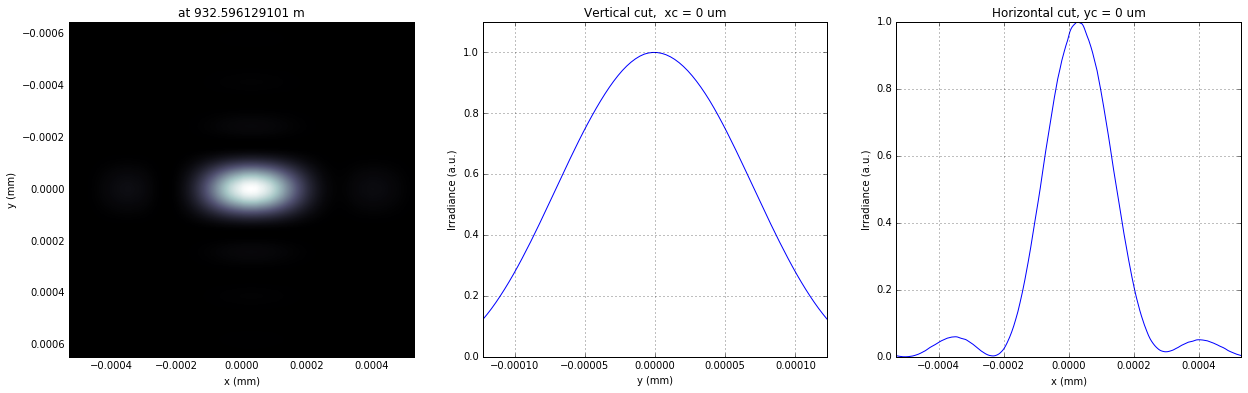

In [13]:
print ('*****Focused beam: Focused beam: perfect KB')
bOnePlot = True
isHlog = False
isVlog = False
plot_wfront(mwf, 'at '+str(z1+z2+z3+z4)+' m',isHlog, isVlog, 1e-5,1e-5,'x', bOnePlot)
#pylab.set_cmap('bone') #set color map, 'bone', 'hot', etc
pylab.axis('tight')    
print 'FWHMx [um], FWHMy [um]:',calculate_fwhm_x(mwf)*1e6,calculate_fwhm_y(mwf)*1e6

### Defining OPD for HKB and VKB

*****HKB and VKB OPD from data  profiles 
*****VKB data  


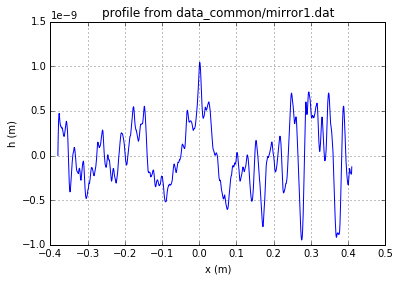

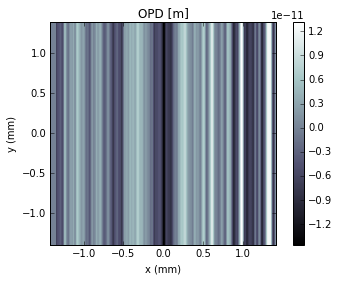

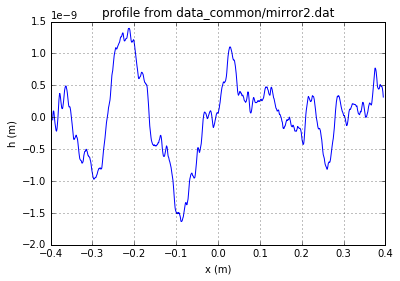

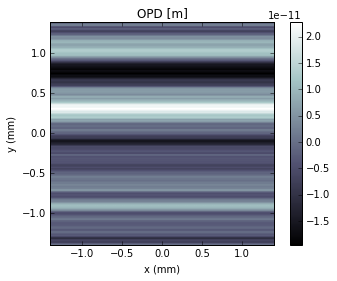

In [14]:
print('*****HKB and VKB OPD from data  profiles ')
scale = 2 #scaling factor of mirror
opTrErHKB = SRWLOptT(1500, 100, horApKB, horApKB)
defineOPD(opTrErHKB, os.path.join(strInputDataFolder,'mirror1.dat'), 2, '\t', 'x',  thetaOM, scale)
opdTmp=numpy.array(opTrErHKB.arTr)[1::2].reshape(opTrErHKB.mesh.ny,opTrErHKB.mesh.nx)
figure()
plot_2d(opdTmp, opTrErM1.mesh.xStart*1e3,opTrErM1.mesh.xFin*1e3,opTrErM1.mesh.yStart*1e3,opTrErM1.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')  
print('*****VKB data  ')
opTrErVKB = SRWLOptT(100, 1500, horApKB, horApKB)
defineOPD(opTrErVKB, os.path.join(strInputDataFolder,'mirror2.dat'), 2, ' ', 'y',  thetaOM, scale)
opdTmp=numpy.array(opTrErVKB.arTr)[1::2].reshape(opTrErVKB.mesh.ny,opTrErVKB.mesh.nx)
figure()
plot_2d(opdTmp, opTrErVKB.mesh.xStart*1e3,opTrErVKB.mesh.xFin*1e3,opTrErVKB.mesh.yStart*1e3,opTrErVKB.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')  

### Propagating through BL2 beamline. Focused beam: imperfect KB

In [15]:
print ('*****Focused beam on focus: imperfect KB')
z3 = dhkb_vkb
z4 = dvkb_foc #distance to focal plane
#z4 = vkbfoc  #focus distance of lens

HKB = SRWLOptL(hkbfoc) #HKB as Thin Lens
#VKB = SRWLOptL(1e23,vkbfoc) #VKB as Thin Lens
#HKB = defineEFM('x', d2hkb, dhkb_foc, thetaKB, thetaKB, 0.85) #HKB Ellipsoidal Mirror
#VKB = defineEFM('y', d2vkb, dvkb_foc, thetaKB, thetaKB, 0.85) #VKB Ellipsoidal Mirror
if not NEW_SYNTAX: Drift_foc = SRWLOptD(z4)
optBL2 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,opTrErHKB,  Drift_KB,  VKB,opTrErVKB,  Drift_foc], 
                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppTrErM1,ppDrift_KB,ppVKB,ppTrErM1, ppDrift_foc]) 
optBL = optBL2
strBL = 'bl2'
pos_title = 'at sample position'
print '*****setting-up optical elements, beamline:', strBL
bl = Beamline(optBL)
bl.append(Empty(), Use_PP(zoom=0.02, sampling=5.0))
print bl

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print 'save hdf5:', out_file_name
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print 'propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min'

*****Focused beam on focus: imperfect KB
*****setting-up optical elements, beamline: bl2
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028
	Dy = 0.0028313537
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0014
		xStart = -0.0014
		yFin = 0.00141567685
		yStart = -0.00141567685
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 683.1
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 0.6, 8.0, 0.6, 4.0, 0, 0, 0]
	Dx = 0.0028
	Dy = 0.0028
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical E

*****Focused beam behind focus: imperfect KB
FWHMx [mm]: 0.0002359219989
FWHMy [mm]: 0.00015539020366
Coordinates of center, [mm]: -2.99684701305e-05 -1.5539020366e-06
stepX, stepY [um]: 0.00127525404811 0.00310780407321 

zero-size array to reduction operation minimum which has no identity
FWHMx [um], FWHMy [um]: 0.2359219989 0.15539020366


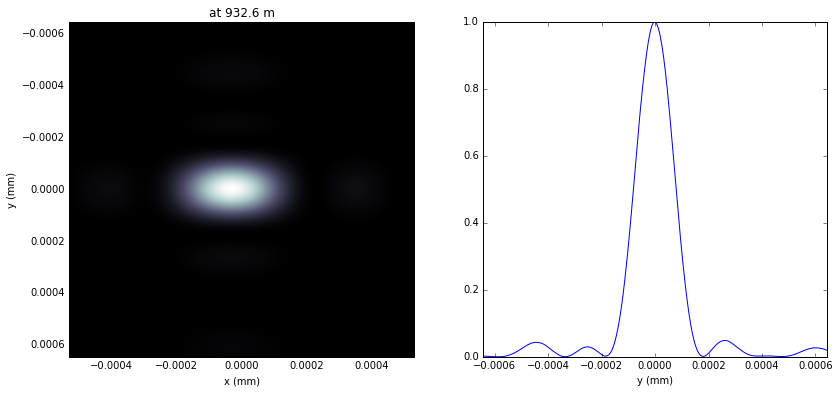

In [16]:
print ('*****Focused beam behind focus: imperfect KB')
bOnePlot= True
isHlog = False
isVlog = False
bSaved = True
try:
    plot_wfront(mwf, 'at '+str(z1+z2+z3+z4)+' m',isHlog, isVlog, 1e-3,1e-3,'x', bOnePlot)
except ValueError,e:
    print e
#pylab.set_cmap('bone') #set color map, 'bone', 'hot', etc
pylab.axis('tight')    
print 'FWHMx [um], FWHMy [um]:',calculate_fwhm_x(mwf)*1e6,calculate_fwhm_y(mwf)*1e6

### Propagating through BL4 beamline. Focused beam: perfect KB

In [17]:
print ('*****Focused beam behind focus: misaligned perfect KB')
z3 = dhkb_vkb
#z4 = dvkb_foc #distance to focal plane
theta0 = thetaKB + 50e-6
p = d2hkb
q = dhkb_foc
R0 = 2./(1./p+1./q)/thetaKB
q_mis = 1./(2/(R0*theta0)-1./p)
offset = q_mis - q #79e-3 if \Delta\theta 10 urad#0. if thetaKB0 = thetaKB
print 'Distance to focus, without and with misalignment:', q,q_mis, 'm'
z4 = dvkb_foc+(q_mis-q) #distance to focal plane
if not NEW_SYNTAX: Drift_foc = SRWLOptD(z4)
HKB = defineEFM('x', d2hkb, dhkb_foc, thetaKB, theta0, 0.85) #HKB Ellipsoidal Mirror
VKB = defineEFM('y', d2vkb, dvkb_foc, thetaKB, thetaKB, 0.85) #VKB Ellipsoidal Mirror
optBL4 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,   Drift_KB,  VKB,  Drift_foc], 
                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppDrift_KB,ppVKB, ppDrift_foc]) 
optBL = optBL4
strBL = 'bl4'
pos_title = 'at new focal plane, misalidned KB angle:'+str(theta0)
print '*****setting-up optical elements, beamline:', strBL
bl = Beamline(optBL)
bl.append(Empty(), Use_PP(zoom_h=0.2, sampling_h=5.0))
print bl

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print 'save hdf5:', out_file_name
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print 'propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min'

*****Focused beam behind focus: misaligned perfect KB
Distance to focus, without and with misalignment: 3.0 3.04299743349 m
*****setting-up optical elements, beamline: bl4
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028
	Dy = 0.0028313537
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0014
		xStart = -0.0014
		yFin = 0.00141567685
		yStart = -0.00141567685
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 683.1
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 0.6, 8.0, 0.6, 4.0, 0,

*****Focused beam behind focus: misaligned ideal KB
FWHMx [mm]: 0.00111041518608
FWHMy [mm]: 0.060995640438
Coordinates of center, [mm]: 0.000334158702679 -0.0258777034143
stepX, stepY [um]: 0.00129268356936 0.0504930798328 

FWHMx [um], FWHMy [um]: 1.11041518608 60.995640438


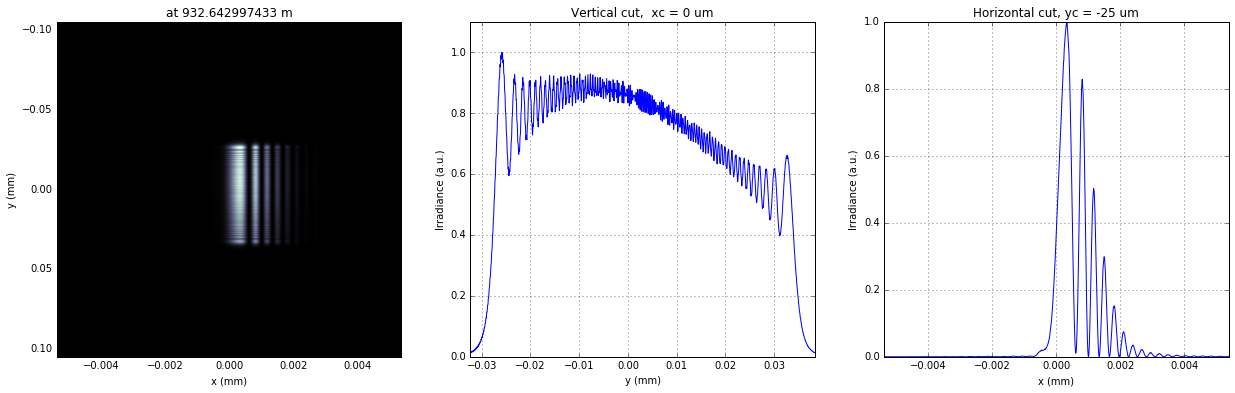

In [18]:
print ('*****Focused beam behind focus: misaligned ideal KB')
pos_title = 'at new focal plane, misalidned KB angle:'+str(theta0)
bOnePlot= True
isHlog = False
isVlog = False
bSaved = True
plot_wfront(mwf, 'at '+str(z1+z2+z3+z4)+' m',isHlog, isVlog, 1e-3,1e-3,'x', bOnePlot)
#pylab.set_cmap('bone') #set color map, 'bone', 'hot', etc
pylab.axis('tight')    
print 'FWHMx [um], FWHMy [um]:',calculate_fwhm_x(mwf)*1e6,calculate_fwhm_y(mwf)*1e6

at new focal plane, misalidned KB angle:0.00355


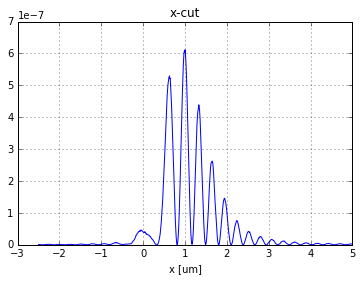

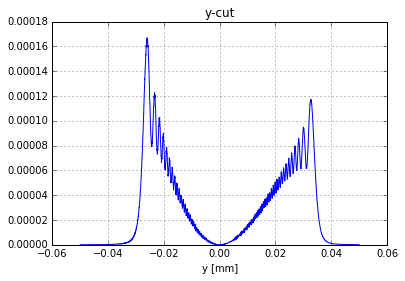

In [19]:
print 'at new focal plane, misalidned KB angle:'+str(theta0)
x,y = intensity_cut(mwf, axis='x', polarization='v', x0=-2.5e-6, x1=5.e-6)
pylab.figure()
pylab.title('x-cut')
pylab.plot(x*1e6,y) # x in [um]
pylab.grid(True)
pylab.xlabel('x [um]')

x,y = intensity_cut(mwf, axis='y', polarization='v', x0=-0.05e-3, x1=0.05e-3)
pylab.figure()
pylab.title('y-cut')
pylab.plot(x*1e3,y) # x in [mm]
pylab.grid(True)
pylab.xlabel('y [mm]')